In [89]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [90]:
#Read data
df_raw = pd.read_csv('fraud.csv')

In [91]:
#Preview data
df_raw.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [92]:
#Explore data types
df_raw.dtypes

step             int64
customer        object
age             object
gender          object
zipcodeOri      object
merchant        object
zipMerchant     object
category        object
amount         float64
fraud            int64
dtype: object

In [93]:
#Explore nulls
df_raw.info() # We have no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [94]:
#Study cardinality of each column
columns = df_raw.columns.tolist()

for column in columns:
    print(f"{column}: {df_raw[column].nunique()} unique values") 

step: 180 unique values
customer: 4112 unique values
age: 8 unique values
gender: 4 unique values
zipcodeOri: 1 unique values
merchant: 50 unique values
zipMerchant: 1 unique values
category: 15 unique values
amount: 23767 unique values
fraud: 2 unique values


**Removing Irrelevant Features:**  
The columns `zipcodeOri` and `zipMerchant` are being dropped from the dataset because they have no variability (constant values) and do not contribute meaningful information for fraud detection. Removing such features helps simplify the dataset and avoids introducing noise into the analysis or modeling process.

In [95]:
df_raw.drop(columns=['zipcodeOri', 'zipMerchant'], inplace=True) 

In [96]:
# High-level analysis of the dataset
total_transactions = len(df_raw)
total_fraud_transactions = df_raw['fraud'].sum()
fraud_rate_by_count = (total_fraud_transactions / total_transactions) * 100

total_amount = df_raw['amount'].sum()
fraud_amount = df_raw[df_raw['fraud'] == 1]['amount'].sum()
fraud_rate_by_amount = (fraud_amount / total_amount) * 100

total_merchants = df_raw['merchant'].nunique()
total_customers = df_raw['customer'].nunique()

print("High-Level Dataset Analysis:")
print(f"Total Customers: {total_customers}")
print(f"Total Merchants: {total_merchants}")
print(f"Total Transactions: {total_transactions}")
print(f"Total Fraud Transactions: {total_fraud_transactions}")
print(f"Fraud Rate by Transaction Count: {fraud_rate_by_count:.2f}%")
print(f"Total Amount: {total_amount:.2f}")
print(f"Total Fraud Amount: {fraud_amount:.2f}")
print(f"Fraud Rate by Amount: {fraud_rate_by_amount:.2f}%")

High-Level Dataset Analysis:
Total Customers: 4112
Total Merchants: 50
Total Transactions: 594643
Total Fraud Transactions: 7200
Fraud Rate by Transaction Count: 1.21%
Total Amount: 22531103.73
Total Fraud Amount: 3822671.17
Fraud Rate by Amount: 16.97%


In [97]:
# Calculate average transaction amount for fraud and non-fraud transactions
avg_amount_fraud = df_raw[df_raw['fraud'] == 1]['amount'].mean()
avg_amount_nonfraud = df_raw[df_raw['fraud'] == 0]['amount'].mean()

# Calculate percentage difference
percent_bigger = ((avg_amount_fraud - avg_amount_nonfraud) / avg_amount_nonfraud) * 100

print(f"Average transaction amount (Fraud): {avg_amount_fraud:.2f}")
print(f"Average transaction amount (Non-Fraud): {avg_amount_nonfraud:.2f}")
print(f"Fraud transactions are on average {percent_bigger:.2f}% higher than non-fraud transactions.")

Average transaction amount (Fraud): 530.93
Average transaction amount (Non-Fraud): 31.85
Fraud transactions are on average 1567.10% higher than non-fraud transactions.


**Amount is a Key Predictor:**  
The large difference between the fraud rate by count (1.21%) and the fraud rate by amount (16.98%) strongly suggests that the `amount` of a transaction is a very powerful feature for predicting fraud. High-value transactions are inherently more suspicious in this dataset, as fraudulent activity tends to target larger sums of

In [98]:
#Convert step to hour_of_day
df_raw['hour_of_day'] = df_raw['step'] % 24

#Make feature to indicate if transaction was made at night, since this might be a fraud indicator
df_raw['is_night'] = (df_raw['hour_of_day'] >= 0) & (df_raw['hour_of_day'] <= 6)


In [99]:
df_raw['age'].value_counts()

age
'2'    187310
'3'    147131
'4'    109025
'5'     62642
'1'     58131
'6'     26774
'0'      2452
'U'      1178
Name: count, dtype: int64

In [100]:
df_raw[df_raw['age'] == "'U'"]['gender'].unique()

array(["'E'"], dtype=object)

- All unknown age rows are Enterprise Customers, so basically these are not missing values

In [101]:
df_raw[df_raw['gender'] == "'E'"]['age'].unique()

array(["'U'"], dtype=object)

- All Enterprise Customers have an unknown age

**Hanndling unknown 'age' for Enterprise Customers:**

The original 'age' column represents age groups as categorical values representign age buckets. To leverage this information effectively in a machine learning model, the following transformations are applied:

1.  **Ordinal Encoding:** The age groups will be treated as ordinal, since they have a meaningful order. They are mapped to numerical values (0-6) to preserve this order.

2.  **Handling Unknown Values for Enterprise:** The missing values in the 'age_ord' column are filled with -1 to distinguish individuals from enterprises.

This approach allows the model to utilize the ordinal nature of the age groups while also accounting for enterprises.

In [102]:
#Convert Buckets to Numeric 
valid_buckets = {"'" + str(i) + "'": i for i in range(7)}   # '0'->0, ... '6'->6
df_raw['age_ord'] = df_raw['age'].map(valid_buckets).astype('Float64').fillna(-1)


In [103]:
# We can now drop the original age column
df_raw.drop(columns=['age'], inplace=True)

In [104]:
# Total transactions per age_ord
total_trx_by_age = df_raw.groupby('age_ord').size()

# Fraud percentage per age_ord
fraud_percentage_by_age = df_raw.groupby('age_ord')['fraud'].mean() * 100

# Combine into a DataFrame for display
age_summary_df = pd.DataFrame({
    'Total Transactions': total_trx_by_age,
    'Fraud Percentage': fraud_percentage_by_age
})
print(age_summary_df)

         Total Transactions  Fraud Percentage
age_ord                                      
-1.0                   1178          0.594228
 0.0                   2452          1.957586
 1.0                  58131          1.185254
 2.0                 187310          1.251401
 3.0                 147131          1.192815
 4.0                 109025          1.293281
 5.0                  62642          1.095112
 6.0                  26774          0.974826


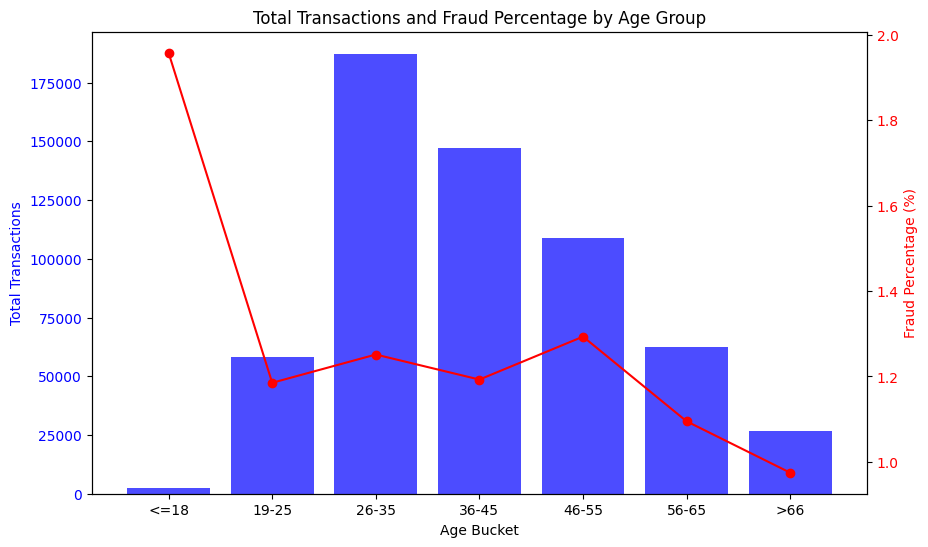

In [105]:
age_plot_df = age_summary_df[age_summary_df.index != -1]

map_cat = {
    0: "<=18",
    1: "19-25",
    2: "26-35",
    3: "36-45",
    4: "46-55",
    5: "56-65",
    6: ">66"
}

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(age_plot_df.index, age_plot_df['Total Transactions'], color='blue', alpha=0.7, label='Total Transactions')
ax1.set_xlabel('Age Bucket')
ax1.set_ylabel('Total Transactions', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Set x-ticks and labels using the mapping
ax1.set_xticks(age_plot_df.index)
ax1.set_xticklabels([map_cat[int(i)] for i in age_plot_df.index])

ax2 = ax1.twinx()
ax2.plot(age_plot_df.index, age_plot_df['Fraud Percentage'], color='red', marker='o', label='Fraud Percentage')
ax2.set_ylabel('Fraud Percentage (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Total Transactions and Fraud Percentage by Age Group')
plt.show()

**Age‐Bucket Insights:**

- The youngest bucket (0) has the highest fraud rate (~2%) but represents a very small share of transactions, so this spike may be driven by low sample size.
- Middle age buckets (1–4) exhibit relatively stable fraud rates around 1.1–1.3%, despite large transaction volumes.
- The oldest bucket (6) shows the lowest fraud rate (~1%) and declining transaction counts.
- The “Unknown” group (–1) contributes negligible volume and a lower fraud rate, so it will have minimal impact

In [106]:
#Exploring Gender feature
df_raw['gender'].value_counts()
df_raw.groupby(['gender', 'fraud']).size()

gender  fraud
'E'     0          1171
        1             7
'F'     0        319807
        1          4758
'M'     0        265950
        1          2435
'U'     0           515
dtype: int64

Even though rows with unknown gender ('U') represent a very small fraction of the dataset (515 out of 594,643) and do not contain any fraudulent transactions. We will keep them in the one hot encoding, and that is to handle missing gender at inference time properly. However, we will not give them their own column, but we will nullify the gender vector in case it was 'U'.

In [107]:
#Exploring Gender Distribution
# Total transactions per gender
total_trx_by_gender = df_raw.groupby('gender').size()

# Fraud percentage per gender
fraud_percentage_by_gender = df_raw.groupby('gender')['fraud'].mean() * 100

gender_summary_df = pd.DataFrame({
    'Total Transactions': total_trx_by_gender,
    'Fraud Percentage': fraud_percentage_by_gender
})
print(gender_summary_df)

        Total Transactions  Fraud Percentage
gender                                      
'E'                   1178          0.594228
'F'                 324565          1.465962
'M'                 268385          0.907279
'U'                    515          0.000000


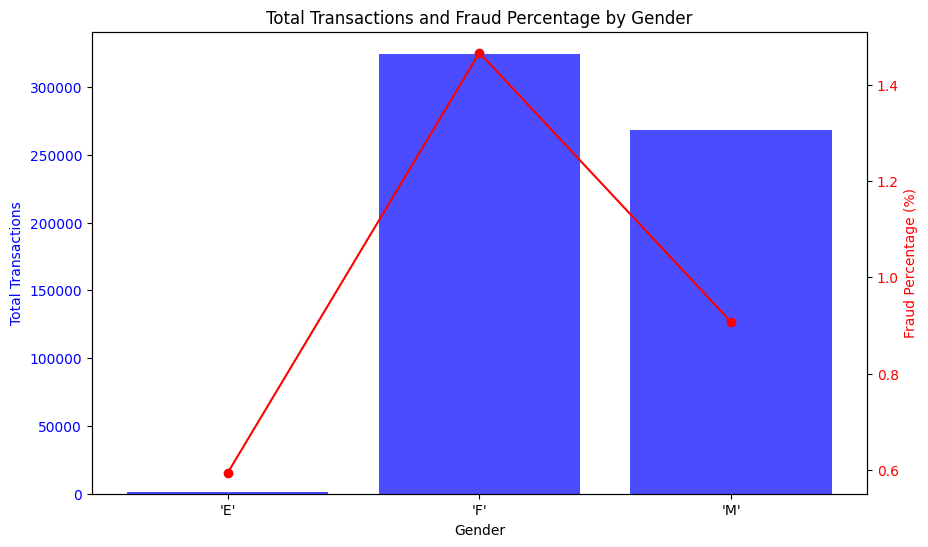

In [108]:
gender_summary_df = gender_summary_df[gender_summary_df.index != "'U'"]
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar for total transactions
ax1.bar(gender_summary_df.index, gender_summary_df['Total Transactions'], color='blue', alpha=0.7, label='Total Transactions')
ax1.set_xlabel('Gender')
ax1.set_ylabel('Total Transactions', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Secondary y-axis for fraud percentage
ax2 = ax1.twinx()
ax2.plot(gender_summary_df.index, gender_summary_df['Fraud Percentage'], color='red', marker='o', label='Fraud Percentage')
ax2.set_ylabel('Fraud Percentage (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Total Transactions and Fraud Percentage by Gender')
plt.show()

**Gender-Based Fraud Insights:**

- Female customers ('F') have a significantly higher fraud rate (1.47%) compared to male customers ('M') at 0.91%.
- The enterprise group ('E') shows the lowest fraud rate (0.59%) and represents a very small portion of transactions, so its impact is minimal.

In [109]:
# Top 5 merchants by fraud rate with at least 500 transactions
merchant_stats = df_raw.groupby('merchant').agg(
    total_transactions=('fraud', 'size'),
    fraud_rate=('fraud', 'mean')
).reset_index()

merchant_stats_filtered = merchant_stats[merchant_stats['total_transactions'] >= 500]
top_5_merchants = merchant_stats_filtered.sort_values('fraud_rate', ascending=False).head(5)
top_5_merchants['fraud_rate'] *= 100
print("Top 5 Merchants by Fraud Rate (>=500 transactions):")
print(top_5_merchants)

# Merchants with fraud rate above 20%
high_risk_merchants = merchant_stats[merchant_stats['fraud_rate'] > 0.20].copy()
high_risk_merchants['fraud_rate'] *= 100
print("\nMerchants with Fraud Rate >20%:")
print(high_risk_merchants.sort_values('fraud_rate', ascending=False))

Top 5 Merchants by Fraud Rate (>=500 transactions):
         merchant  total_transactions  fraud_rate
40   'M732195782'                 608   85.197368
49   'M980657600'                1769   83.210854
34   'M480139044'                3508   46.579247
15  'M1741626453'                 528   37.121212
22  'M1888755466'                 912   25.000000

Merchants with Fraud Rate >20%:
         merchant  total_transactions  fraud_rate
3   'M1294758098'                 191   96.335079
32     'M3697346'                 308   94.155844
21  'M1873032707'                 250   86.400000
40   'M732195782'                 608   85.197368
49   'M980657600'                1769   83.210854
6   'M1353266412'                  78   82.051282
44   'M857378720'                 122   75.409836
26  'M2080407379'                  48   75.000000
25  'M2011752106'                 244   68.032787
14    'M17379832'                 282   63.120567
28  'M2122776122'                 341   58.651026
34   'M48013904

/var/folders/_8/2v5bb8x12dg6769g7d_vw30c0000gn/T/ipykernel_98445/3330996699.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_5_merchants['merchant'], rotation=45, ha='right')


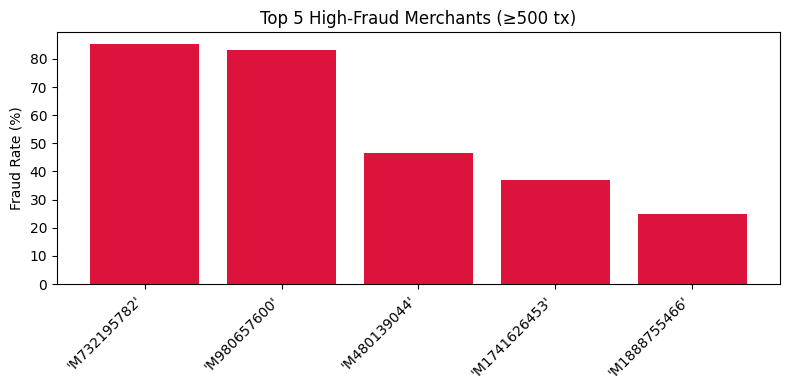

In [110]:
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(top_5_merchants['merchant'], top_5_merchants['fraud_rate'], color='crimson')
ax.set_xticklabels(top_5_merchants['merchant'], rotation=45, ha='right')
ax.set_ylabel('Fraud Rate (%)')
ax.set_title('Top 5 High-Fraud Merchants (≥500 tx)')
plt.tight_layout()
plt.show()

In [111]:
# Calculate fraud rate by amount for each merchant
merchant_amount_stats = df_raw.groupby('merchant').agg(
    count_of_trx=('fraud', 'size'),
    total_amount=('amount', 'sum'),
    fraud_amount=('amount', lambda x: x[df_raw.loc[x.index, 'fraud'] == 1].sum())
).reset_index()

# Calculate fraud rate by amount
merchant_amount_stats['fraud_rate_by_amount'] = merchant_amount_stats['fraud_amount'] / merchant_amount_stats['total_amount']

# Sort by fraud rate by amount descending and get top 5
top_5_merchants_by_amount_fraud = merchant_amount_stats.sort_values('fraud_rate_by_amount', ascending=False).head(5)

# Convert to percentage
top_5_merchants_by_amount_fraud['fraud_rate_by_amount'] *= 100

print("Top 5 Merchants by Fraud Rate by Amount:")

top_5_merchants_by_amount_fraud

Top 5 Merchants by Fraud Rate by Amount:


,merchant,count_of_trx,total_amount,fraud_amount,fraud_rate_by_amount
3,'M1294758098',191,55326.42,54808.34,99.063594
32,'M3697346',308,88840.32,87527.64,98.522428
21,'M1873032707',250,94059.33,90653.68,96.379253
6,'M1353266412',78,29470.62,28180.77,95.623268
40,'M732195782',608,1413661.65,1350979.31,95.565959


In [112]:
customer_amount_stats = df_raw.groupby('customer').agg(
    total_amount=('amount', 'sum'),
    fraud_amount=('amount', lambda x: x[df_raw.loc[x.index, 'fraud'] == 1].sum())
).reset_index()

# Calculate fraud rate by amount
customer_amount_stats['fraud_rate_by_amount'] = customer_amount_stats['fraud_amount'] / customer_amount_stats['total_amount']

# Sort by fraud rate by amount descending and get top 5
top_5_customers_by_amount_fraud = customer_amount_stats.sort_values('fraud_rate_by_amount', ascending=False).head(5)

# Convert to percentage
top_5_customers_by_amount_fraud['fraud_rate_by_amount'] *= 100

print("Top 5 Customers by Fraud Rate by Amount:")
print(top_5_customers_by_amount_fraud)

Top 5 Customers by Fraud Rate by Amount:
           customer  total_amount  fraud_amount  fraud_rate_by_amount
1249  'C1572610482'      58687.13      58203.13             99.175288
2187  'C2004941826'      64751.08      64165.54             99.095706
2296  'C2060410910'       7305.33       7213.91             98.748585
3308   'C617723960'      23823.87      23443.52             98.403492
3926   'C910454738'      37795.51      37143.84             98.275800


**Customer-Level Fraud Insights:**

The analysis above reveals that certain customers have an extremely high concentration of fraudulent transaction amounts, with fraud rates exceeding 98%. This strong pattern suggests that customer historical behavior is a valuable signal for fraud prediction. By engineering features that capture a customer's past transaction patterns such as their historical fraud rate, average transaction amount, or changes in behavior over time we can provide the model with powerful context to identify suspicious activity. Leveraging these customer-level features will help the model distinguish between normal and anomalous behavior, improving its ability to detect fraud more accurately.

In [113]:
# Group by category to calculate fraud rates by count and by amount
category_stats = df_raw.groupby('category').agg(
    total_transactions=('fraud', 'size'),
    fraud_transactions=('fraud', 'sum'),
    total_amount=('amount', 'sum'),
    avg_trx_amount=('amount', 'mean'),
    fraud_amount=('amount', lambda x: x[df_raw.loc[x.index, 'fraud'] == 1].sum()),
    number_of_merchants=('merchant', 'nunique')
).reset_index()

# Calculate fraud rate by count (percentage of fraudulent transactions)
category_stats['fraud_rate_by_count'] = (category_stats['fraud_transactions'] / category_stats['total_transactions']) * 100

# Calculate fraud rate by amount (percentage of fraudulent amount)
category_stats['fraud_rate_by_amount'] = (category_stats['fraud_amount'] / category_stats['total_amount']) * 100

# Display the results
print("Category Fraud Statistics:")
category_stats.sort_values(by='fraud_rate_by_amount', ascending=False)


Category Fraud Statistics:


,category,total_transactions,fraud_transactions,total_amount,avg_trx_amount,fraud_amount,number_of_merchants,fraud_rate_by_count,fraud_rate_by_amount
8,'es_leisure',499,474,144166.74,288.911303,142335.98,2,94.989980,98.730109
13,'es_travel',728,578,1638297.89,2250.409190,1537944.06,4,79.395604,93.874507
10,'es_sportsandtoys',4002,1982,863292.55,215.715280,684517.02,6,49.525237,79.291431
6,'es_hotelservices',1744,548,358591.25,205.614249,231159.19,7,31.422018,64.463143
9,'es_otherservices',912,228,123923.95,135.881524,72155.07,1,25.000000,58.225283
5,'es_home',1986,302,329022.30,165.670846,138160.42,5,15.206445,41.991202
4,'es_health',16133,1696,2187979.51,135.621367,690325.15,5,10.512614,31.550805
11,'es_tech',2370,158,286646.61,120.947937,65613.31,3,6.666667,22.889965
7,'es_hyper',6098,280,280327.63,45.970421,47391.52,1,4.591669,16.905761
14,'es_wellnessandbeauty',15086,718,988302.28,65.511221,164725.38,7,4.759380,16.667510


In [114]:
# Distribution of fraud amount across categories

# Filter for fraudulent transactions
fraud_df = df_raw[df_raw['fraud'] == 1]

# Group by category and sum the amount
fraud_amount_by_category = fraud_df.groupby('category')['amount'].sum().reset_index()

# Calculate total fraud amount
total_fraud_amount = fraud_amount_by_category['amount'].sum()

# Calculate percentage distribution
fraud_amount_by_category['percentage'] = (fraud_amount_by_category['amount'] / total_fraud_amount) * 100

print("Fraud Amount Distribution by Category:")

fraud_amount_by_category.sort_values('amount', ascending=False)

Fraud Amount Distribution by Category:


,category,amount,percentage
10,'es_travel',1537944.06,40.232183
2,'es_health',690325.15,18.058711
8,'es_sportsandtoys',684517.02,17.906772
4,'es_hotelservices',231159.19,6.047059
11,'es_wellnessandbeauty',164725.38,4.309169
6,'es_leisure',142335.98,3.723469
3,'es_home',138160.42,3.614238
7,'es_otherservices',72155.07,1.887556
9,'es_tech',65613.31,1.716426
5,'es_hyper',47391.52,1.239749


In [115]:
# Distribution of fraud amount across categories

# Filter for fraudulent transactions
fraud_df = df_raw[df_raw['fraud'] == 1]

# Group by category and sum the amount
fraud_count_by_category = fraud_df.groupby('category')['fraud'].sum().reset_index()

# Calculate total fraud count
total_fraud_count = fraud_count_by_category['fraud'].sum()

# Calculate percentage distribution
fraud_count_by_category['percentage'] = (fraud_count_by_category['fraud'] / total_fraud_count) * 100

print("Fraud Count Distribution by Category:")
fraud_count_by_category.sort_values('fraud', ascending=False)


Fraud Count Distribution by Category:


,category,fraud,percentage
8,'es_sportsandtoys',1982,27.527778
2,'es_health',1696,23.555556
11,'es_wellnessandbeauty',718,9.972222
10,'es_travel',578,8.027778
4,'es_hotelservices',548,7.611111
6,'es_leisure',474,6.583333
3,'es_home',302,4.194444
5,'es_hyper',280,3.888889
7,'es_otherservices',228,3.166667
9,'es_tech',158,2.194444


**Category Mapping & Cardinality Reduction:**

I mapped the original `category` column into broader groups such as "Travel & Leisure", "Food & Hospitality", "Retail & Lifestyle", "Tech & Digital", and "Services & Miscellaneous". This reduces the number of unique values (cardinality) in the category feature.

Reducing cardinality is important because one-hot encoding high-cardinality columns can create a large number of new features, leading to the "exploding columns" problem. This can make the dataset sparse, increase memory usage, and potentially harm model performance due to overfitting and slower training. By grouping categories, we simplify the feature space, making the model more

In [116]:
# Map category to new groups
category_mapping = {
    "'es_travel'": 'Travel & Leisure',
    "'es_leisure'": 'Travel & Leisure',
    "'es_sportsandtoys'": 'Travel & Leisure',
    "'es_hotelservices'": 'Travel & Leisure',
    "'es_barsandrestaurants'": 'Food & Hospitality',
    "'es_food'": 'Food & Hospitality',
    "'es_contents'": 'Food & Hospitality',
    "'es_fashion'": 'Retail & Lifestyle',
    "'es_home'": 'Retail & Lifestyle',
    "'es_wellnessandbeauty'": 'Retail & Lifestyle',
    "'es_hyper'": 'Retail & Lifestyle',
    "'es_tech'": 'Tech & Digital',
    "'es_otherservices'": 'Services & Miscellaneous',
    "'es_health'": 'Services & Miscellaneous',
    "'es_transportation'": 'Services & Miscellaneous'
}

df_raw['category_mapped'] = df_raw['category'].map(category_mapping).fillna('Services & Miscellaneous')

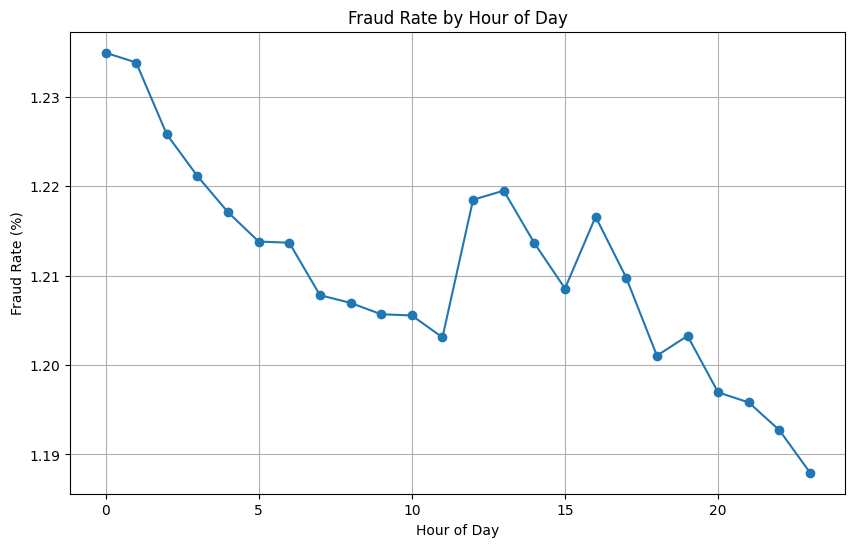

In [117]:
fraud_rate_by_step = df_raw.groupby('hour_of_day')['fraud'].mean()

plt.figure(figsize=(10, 6))
plt.plot(fraud_rate_by_step.index, fraud_rate_by_step.values * 100, marker='o')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate (%)')
plt.grid(True)
plt.show()

- We can see higher Fraud rates at night times (midnight till 6 AM)

In [118]:
#Handle categorical variables by one hot encoding (Category + Gender)

from sklearn.preprocessing import OneHotEncoder
category_ohe = OneHotEncoder()

#One hot encode the mapped category column
category_encoded = category_ohe.fit_transform(df_raw[['category_mapped']])
category_columns = category_ohe.get_feature_names_out(['category_mapped'])
category_df = pd.DataFrame(category_encoded.toarray(), 
                          columns=category_columns,
                          index=df_raw.index)


#One hot encode the gender column


#Fill unkowns with NaN so we dont have a seperate column for unknowns genders
df_raw['gender'] = np.where(
    df_raw['gender'] == "'U'", np.nan, df_raw['gender']
)

gender_ohe = OneHotEncoder(
    categories=[["'E'","'F'","'M'"]],
    handle_unknown='ignore',
    sparse_output=True,
    dtype=np.int8
)

gender_encoded = gender_ohe.fit_transform(df_raw[['gender']])
gender_columns = gender_ohe.get_feature_names_out(['gender'])
gender_df = pd.DataFrame(gender_encoded.toarray(), 
                          columns=gender_columns,
                          index=df_raw.index)


In [119]:
df_raw = pd.concat([df_raw.drop(columns=['gender']), category_df, gender_df], axis=1)

In [120]:
df_raw.columns

Index(['step', 'customer', 'merchant', 'category', 'amount', 'fraud',
       'hour_of_day', 'is_night', 'age_ord', 'category_mapped',
       'category_mapped_Food & Hospitality',
       'category_mapped_Retail & Lifestyle',
       'category_mapped_Services & Miscellaneous',
       'category_mapped_Tech & Digital', 'category_mapped_Travel & Leisure',
       'gender_'E'', 'gender_'F'', 'gender_'M''],
      dtype='object')

In [121]:
# Customer-level features
# Sort by customer and step to avoid leakage from future to past
df_cust = df_raw.sort_values(['customer','step']).reset_index(drop=True)


# Group by customer
g = df_cust.groupby('customer', group_keys=False)

# Change in amount from previous transaction
df_cust['cust_prev_amount']      = g['amount'].shift(1)
df_cust['cust_amount_diff_prev'] = df_cust['amount'] - df_cust['cust_prev_amount']
df_cust['cust_amount_pctchg_prev'] = df_cust['cust_amount_diff_prev'] / (df_cust['cust_prev_amount'].replace(0, np.nan))

# Change in amount from historical mean (z-score)
df_cust['cust_hist_mean']        = g['amount'].apply(lambda s: s.shift(1).expanding().mean())
df_cust['cust_hist_std']         = g['amount'].apply(lambda s: s.shift(1).expanding().std()).fillna(0.0)
df_cust['cust_amount_z']         = (df_cust['amount'] - df_cust['cust_hist_mean']) / df_cust['cust_hist_std'].replace(0, np.nan)

# Flag to indicate if amount is higher than previous transaction
df_cust['cust_higher_than_prev'] = (df_cust['amount'] > df_cust['cust_prev_amount']).astype('Int8')

# Time since previous transaction
df_cust['cust_hours_since_prev'] = df_cust['step'] - g['step'].shift(1)

In [122]:
# Merchant-level features
# Sort by merchant and step to avoid leakage from future to past
df_merchant = df_cust.sort_values(['merchant','step']).reset_index(drop=True)

# Group by merchant
g_merchant = df_merchant.groupby('merchant', group_keys=False)

# Change in amount from previous transaction
df_merchant['merch_prev_amount']      = g_merchant['amount'].shift(1)
df_merchant['merch_amount_diff_prev'] = df_merchant['amount'] - df_merchant['merch_prev_amount']
df_merchant['merch_amount_pctchg_prev'] = df_merchant['merch_amount_diff_prev'] / (df_merchant['merch_prev_amount'].replace(0, np.nan))

# Change in amount from historical mean (z-score)
df_merchant['merch_hist_mean']        = g_merchant['amount'].apply(lambda s: s.shift(1).expanding().mean())
df_merchant['merch_hist_std']         = g_merchant['amount'].apply(lambda s: s.shift(1).expanding().std()).fillna(0.0)
df_merchant['merch_amount_z']         = (df_merchant['amount'] - df_merchant['merch_hist_mean']) / df_merchant['merch_hist_std'].replace(0, np.nan)


In [123]:
# Category-level features
# Sort by category and step to avoid leakage from future to past
df_cat = df_merchant.sort_values(['category','step']).reset_index(drop=True)

# Group by category
g_cat = df_cat.groupby('category', group_keys=False)

# Change in amount from previous transaction
df_cat['cat_prev_amount']      = g_cat['amount'].shift(1)
df_cat['cat_amount_diff_prev'] = df_cat['amount'] - df_cat['cat_prev_amount']
df_cat['cat_amount_pctchg_prev'] = df_cat['cat_amount_diff_prev'] / (df_cat['cat_prev_amount'].replace(0, np.nan))

# Change in amount from historical mean (z-score)
df_cat['cat_hist_mean']        = g_cat['amount'].apply(lambda s: s.shift(1).expanding().mean())
df_cat['cat_hist_std']         = g_cat['amount'].apply(lambda s: s.shift(1).expanding().std()).fillna(0.0)
df_cat['cat_amount_z']         = (df_cat['amount'] - df_cat['cat_hist_mean']) / df_cat['cat_hist_std'].replace(0, np.nan)


In [124]:
# Sort df_cat by customer, merchant, and step to ensure correct ranking
df_rank = df_cat.sort_values(['customer', 'merchant', 'step']).reset_index(drop=True)

# Rank transactions per customer (regardless of merchant)
df_rank['cust_trx_rank'] = df_rank.groupby('customer').cumcount() + 1

# Add cumulative transaction rank per customer-merchant pair
df_rank['cust_merch_trx_rank'] = df_rank.groupby(['customer', 'merchant']).cumcount() + 1

# For merchant ranking, we need to sort by step globally, then group by merchant
df_temp = df_rank.sort_values('step').reset_index(drop=True)
df_temp['temp_rank'] = df_temp.groupby('merchant').cumcount() + 1

# Merge back the merchant rank to our main dataframe
df_rank = df_rank.merge(
    df_temp[['customer', 'merchant', 'step', 'temp_rank']], 
    on=['customer', 'merchant', 'step'], 
    how='left'
)
df_rank['merch_trx_rank'] = df_rank['temp_rank']
df_rank.drop('temp_rank', axis=1, inplace=True)


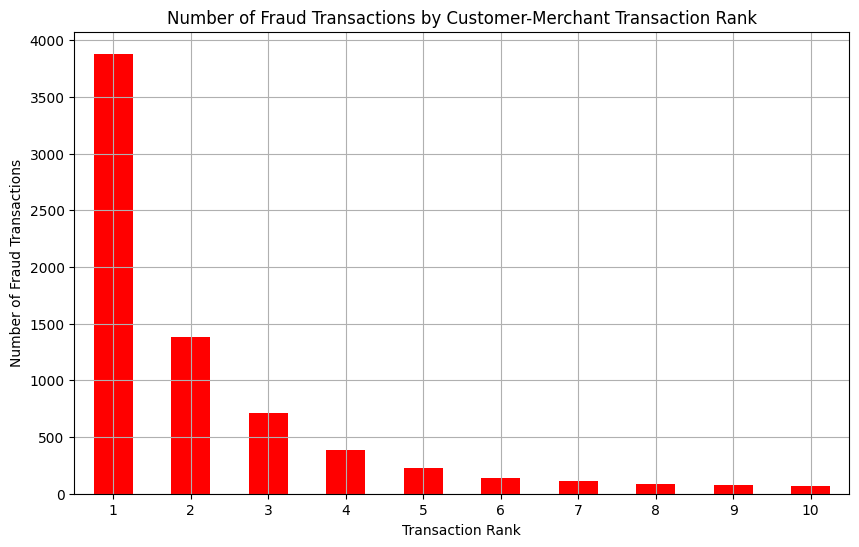

In [125]:
# Group fraud transactions by rank
fraud_by_rank = df_rank[df_rank['fraud'] == 1].groupby('cust_merch_trx_rank').size()

# Plot the top 10 ranks
plt.figure(figsize=(10, 6))
fraud_by_rank.head(10).plot(kind='bar', color='red')
plt.title('Number of Fraud Transactions by Customer-Merchant Transaction Rank')
plt.xlabel('Transaction Rank')
plt.ylabel('Number of Fraud Transactions')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

#### Fraud and Customer-Merchant Transaction Rank

Most fraud transactions occur on the **first transaction** between a customer and a merchant. The number of frauds drops sharply for subsequent transactions. This suggests that fraudsters often target merchants they haven't interacted with before, making transaction rank a useful feature

In [126]:
# Assuming df_rank is already created and sorted
# Add first_fraud column
df_rank['first_fraud'] = df_rank.groupby(['customer', 'merchant'])['fraud'].transform('first')

# Filter for subsequent transactions (rank > 1)
subsequent_df = df_rank[df_rank['cust_merch_trx_rank'] > 1]

# Calculate fraud rate in subsequent transactions based on first transaction's fraud status
fraud_rate_subsequent = subsequent_df.groupby('first_fraud')['fraud'].mean() * 100

print("Fraud rate in subsequent transactions:")
print(f"If first transaction was fraud: {fraud_rate_subsequent.loc[1]:.2f}%")
print(f"If first transaction was not fraud: {fraud_rate_subsequent.loc[0]:.2f}%")

# To check if all subsequent are fraud when first is fraud
groups_first_fraud = df_rank[df_rank['first_fraud'] == 1].groupby(['customer', 'merchant'])
all_subsequent_fraud_count = 0
total_groups = 0
for name, group in groups_first_fraud:
    total_groups += 1
    subsequent = group[group['cust_merch_trx_rank'] > 1]
    if len(subsequent) > 0 and subsequent['fraud'].all():
        all_subsequent_fraud_count += 1

print(f"\nOut of {total_groups} customer-merchant pairs where first transaction was fraud:")
print(f"{all_subsequent_fraud_count} have all subsequent transactions as fraud.")

# For pairs where first is not fraud, check if any subsequent is fraud
groups_first_not_fraud = df_rank[df_rank['first_fraud'] == 0].groupby(['customer', 'merchant'])
any_subsequent_fraud_count = 0
total_groups_not = 0
for name, group in groups_first_not_fraud:
    total_groups_not += 1
    subsequent = group[group['cust_merch_trx_rank'] > 1]
    if len(subsequent) > 0 and subsequent['fraud'].any():
        any_subsequent_fraud_count += 1

print(f"\nOut of {total_groups_not} customer-merchant pairs where first transaction was not fraud:")
print(f"{any_subsequent_fraud_count} have at least one subsequent transaction as fraud.")

Fraud rate in subsequent transactions:
If first transaction was fraud: 80.51%
If first transaction was not fraud: 0.21%

Out of 3823 customer-merchant pairs where first transaction was fraud:
738 have all subsequent transactions as fraud.

Out of 43309 customer-merchant pairs where first transaction was not fraud:
717 have at least one subsequent transaction as fraud.


In [127]:
df_rank.columns

Index(['step', 'customer', 'merchant', 'category', 'amount', 'fraud',
       'hour_of_day', 'is_night', 'age_ord', 'category_mapped',
       'category_mapped_Food & Hospitality',
       'category_mapped_Retail & Lifestyle',
       'category_mapped_Services & Miscellaneous',
       'category_mapped_Tech & Digital', 'category_mapped_Travel & Leisure',
       'gender_'E'', 'gender_'F'', 'gender_'M'', 'cust_prev_amount',
       'cust_amount_diff_prev', 'cust_amount_pctchg_prev', 'cust_hist_mean',
       'cust_hist_std', 'cust_amount_z', 'cust_higher_than_prev',
       'cust_hours_since_prev', 'merch_prev_amount', 'merch_amount_diff_prev',
       'merch_amount_pctchg_prev', 'merch_hist_mean', 'merch_hist_std',
       'merch_amount_z', 'cat_prev_amount', 'cat_amount_diff_prev',
       'cat_amount_pctchg_prev', 'cat_hist_mean', 'cat_hist_std',
       'cat_amount_z', 'cust_trx_rank', 'cust_merch_trx_rank',
       'merch_trx_rank', 'first_fraud'],
      dtype='object')

In [128]:
df_final = df_rank[
    [  'customer', 'merchant', 'step', 'hour_of_day', 'amount',
       'is_night', 'age_ord',
       'category_mapped_Food & Hospitality',
       'category_mapped_Retail & Lifestyle',
       'category_mapped_Services & Miscellaneous',
       'category_mapped_Tech & Digital', 'category_mapped_Travel & Leisure',
       "gender_'E'", "gender_'F'", "gender_'M'",
       'cust_amount_pctchg_prev', 'cust_amount_z', 'cust_higher_than_prev',
       'cust_hours_since_prev','merch_amount_pctchg_prev', 
       'merch_amount_z', 'cat_amount_pctchg_prev', 'cat_amount_z', 'cust_merch_trx_rank',
       'cust_trx_rank', 'merch_trx_rank',
       'fraud']
       ]

In [129]:
df_final.isna().sum()

customer                                       0
merchant                                       0
step                                           0
hour_of_day                                    0
amount                                         0
is_night                                       0
age_ord                                        0
category_mapped_Food & Hospitality             0
category_mapped_Retail & Lifestyle             0
category_mapped_Services & Miscellaneous       0
category_mapped_Tech & Digital                 0
category_mapped_Travel & Leisure               0
gender_'E'                                     0
gender_'F'                                     0
gender_'M'                                     0
cust_amount_pctchg_prev                     4184
cust_amount_z                               8272
cust_higher_than_prev                          0
cust_hours_since_prev                       4132
merch_amount_pctchg_prev                     103
merch_amount_z      

In [130]:
# 2. Fill percentage changes with 0
pct_change_cols = ['cust_amount_pctchg_prev', 'merch_amount_pctchg_prev', 'cat_amount_pctchg_prev']
df_final[pct_change_cols] = df_final[pct_change_cols].fillna(0)

/var/folders/_8/2v5bb8x12dg6769g7d_vw30c0000gn/T/ipykernel_98445/4208954197.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[pct_change_cols] = df_final[pct_change_cols].fillna(0)


In [131]:
z_score_cols = ['cust_amount_z', 'merch_amount_z', 'cat_amount_z']
df_final[z_score_cols] = df_final[z_score_cols].fillna(0)

/var/folders/_8/2v5bb8x12dg6769g7d_vw30c0000gn/T/ipykernel_98445/2418653240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[z_score_cols] = df_final[z_score_cols].fillna(0)


In [132]:
df_final.isna().sum()

customer                                       0
merchant                                       0
step                                           0
hour_of_day                                    0
amount                                         0
is_night                                       0
age_ord                                        0
category_mapped_Food & Hospitality             0
category_mapped_Retail & Lifestyle             0
category_mapped_Services & Miscellaneous       0
category_mapped_Tech & Digital                 0
category_mapped_Travel & Leisure               0
gender_'E'                                     0
gender_'F'                                     0
gender_'M'                                     0
cust_amount_pctchg_prev                        0
cust_amount_z                                  0
cust_higher_than_prev                          0
cust_hours_since_prev                       4132
merch_amount_pctchg_prev                       0
merch_amount_z      

In [133]:
# Train test split based on time (step) to avoid lookahead bias
q_step = df_final['step'].quantile(0.80, interpolation='higher') 
train_idx = df_final['step'] < q_step
test_idx = df_final['step'] >= q_step

train_df = df_final[train_idx].copy()
test_df = df_final[test_idx].copy()

We will sort the dataset by transaction time (`step`) to ensure that all subsequent cross-validation and train-test splits are time-aware. This prevents training on future data to predict the past, which is critical given our extensive use of time-based features. Time-aware splitting maintains the integrity of our modeling process and avoids data leakage.

In [134]:
train_df.sort_values(by = 'step', inplace=True)
test_df.sort_values(by = 'step', inplace=True) 

**Merchant Prior Fraud Feature:**  
A binary feature `merch_had_prior_fraud` is created to indicate whether a merchant has had any fraudulent transactions in the past (for training data) or in the training period (for test data). This helps the model identify merchants with a history of fraud.

In [135]:
# Create a set of merchants with fraud in the training data
fraudulent_merchants_train = set(train_df[train_df['fraud'] == 1]['merchant'])

# Feature for training data: had prior fraud for the merchant
train_df['merch_had_prior_fraud'] = train_df.groupby('merchant')['fraud'].transform(lambda x: x.shift().cumsum()).gt(0).astype(int)

# Feature for test data: did the merchant have fraud in the training data
test_df['merch_had_prior_fraud'] = test_df['merchant'].isin(fraudulent_merchants_train).astype(int)

In [136]:
train_df['fraud'].value_counts(normalize=True)  

fraud
0    0.986819
1    0.013181
Name: proportion, dtype: float64

In [137]:
test_df['fraud'].value_counts(normalize=True)  

fraud
0    0.988963
1    0.011037
Name: proportion, dtype: float64

In [ ]:
# Calculate customer-level and global medians from training data only
train_customer_medians_dict = {'cust_hours_since_prev': train_df.groupby('customer')['cust_hours_since_prev'].median()}
train_global_medians_dict = {'cust_hours_since_prev': train_df['cust_hours_since_prev'].median()}

def impute_with_customer_fallback(df, customer_medians, global_median, column):

    result = df[column].copy()
    
    # Get customer median for each row, fallback to global if customer not in training
    customer_median_values = df['customer'].map(customer_medians).fillna(global_median)
    
    # Fill NaNs with customer-specific or global median
    result = result.fillna(customer_median_values)
    
    return result

# Apply to both train and test (overwrites original column)
train_df['cust_hours_since_prev'] = impute_with_customer_fallback(
    train_df, train_customer_medians_dict['cust_hours_since_prev'], 
    train_global_medians_dict['cust_hours_since_prev'], 'cust_hours_since_prev'
)

test_df['cust_hours_since_prev'] = impute_with_customer_fallback(
    test_df, train_customer_medians_dict['cust_hours_since_prev'], 
    train_global_medians_dict['cust_hours_since_prev'], 'cust_hours_since_prev'
)

In [139]:
train_df.drop(columns=['merchant', 'customer', 'step'], inplace=True)
test_df.drop(columns=['merchant', 'customer', 'step'], inplace=True)

In [140]:
train_df.columns

Index(['hour_of_day', 'amount', 'is_night', 'age_ord',
       'category_mapped_Food & Hospitality',
       'category_mapped_Retail & Lifestyle',
       'category_mapped_Services & Miscellaneous',
       'category_mapped_Tech & Digital', 'category_mapped_Travel & Leisure',
       'gender_'E'', 'gender_'F'', 'gender_'M'', 'cust_amount_pctchg_prev',
       'cust_amount_z', 'cust_higher_than_prev', 'cust_hours_since_prev',
       'merch_amount_pctchg_prev', 'merch_amount_z', 'cat_amount_pctchg_prev',
       'cat_amount_z', 'cust_merch_trx_rank', 'cust_trx_rank',
       'merch_trx_rank', 'fraud', 'merch_had_prior_fraud'],
      dtype='object')

In [141]:
# Split features and labels for training data
X_train = train_df.drop(columns=['fraud'])
y_train = train_df['fraud']

# Split features and labels for testing data
X_test = test_df.drop(columns=['fraud'])
y_test = test_df['fraud']

In [142]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [143]:
# Predict on test set
y_pred = rf_model.predict(X_test)

# Measure Precision, Recall, F1-score for fraud class (assuming fraud=1 is positive)
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud'], digits=3))

              precision    recall  f1-score   support

   Non-Fraud      0.997     1.000     0.998    120962
       Fraud      0.957     0.756     0.844      1350

    accuracy                          0.997    122312
   macro avg      0.977     0.878     0.921    122312
weighted avg      0.997     0.997     0.997    122312



In [144]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Train XGBoost Classifier
xgb_model = XGBClassifier(random_state=42, n_estimators=100)
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

In [145]:
# Measure Precision, Recall, F1-score for fraud class (assuming fraud=1 is positive)
print(classification_report(y_test, y_pred_xgb, target_names=['Non-Fraud', 'Fraud'], digits=3))

              precision    recall  f1-score   support

   Non-Fraud      0.998     0.999     0.998    120962
       Fraud      0.905     0.787     0.842      1350

    accuracy                          0.997    122312
   macro avg      0.951     0.893     0.920    122312
weighted avg      0.997     0.997     0.997    122312



In [146]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from xgboost import XGBClassifier

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 0.8]
}

# Use TimeSeriesSplit for temporal cross-validation
# This ensures we always train on past data and validate on future data
tscv = TimeSeriesSplit(n_splits=3)

rs = RandomizedSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    param_distributions=param_dist,
    n_iter=100,
    cv=tscv,  # Use time-aware cross-validation
    scoring='recall',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Note: We need to sort X_train by time for TimeSeriesSplit to work properly
# Since we already did temporal split, we can use the training data directly
rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
print("Best recall:", rs.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/Users/mahmoudatari/Desktop/Deloitte Assignment/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
Best recall: 0.8023571094508587


In [147]:
# Train best model for recall and evaluate
best_xgb_recall = rs.best_estimator_
y_pred_recall = best_xgb_recall.predict(X_test)
print("Classification Report for Recall-optimized model:")
print(classification_report(y_test, y_pred_recall, target_names=['Non-Fraud', 'Fraud'], digits=3))


Classification Report for Recall-optimized model:
              precision    recall  f1-score   support

   Non-Fraud      0.998     0.999     0.999    120962
       Fraud      0.927     0.830     0.876      1350

    accuracy                          0.997    122312
   macro avg      0.963     0.915     0.937    122312
weighted avg      0.997     0.997     0.997    122312



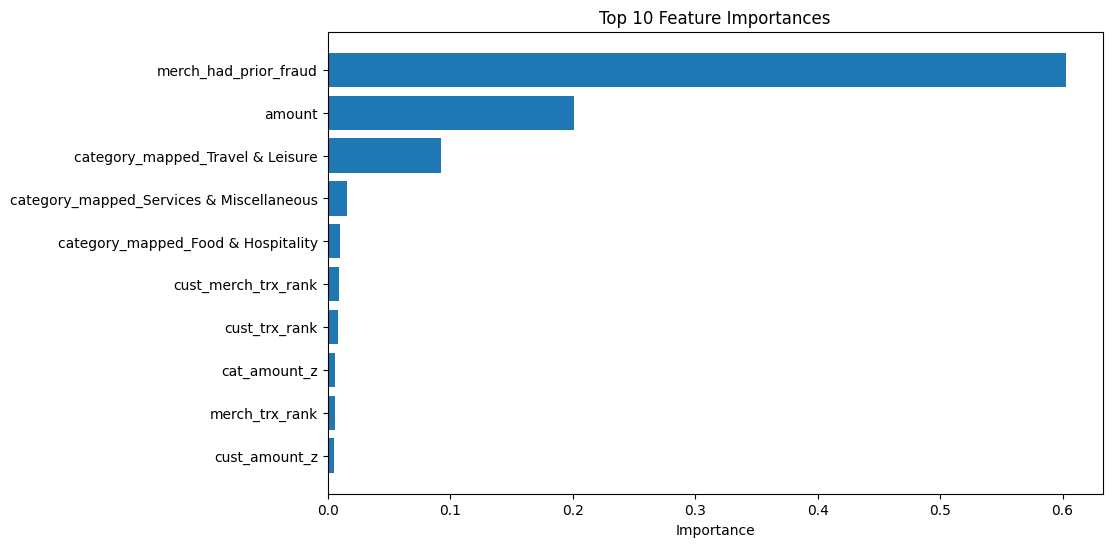

In [148]:
# Assuming rf_model or xgb_model is your trained model
# Replace 'rf_model' with 'xgb_model' if using XGBoost

# Get feature importances
feature_importances = best_xgb_recall.feature_importances_
features = X_train.columns  # Assuming X_train is your feature DataFrame

# Create a DataFrame for plotting
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.show()